# Cell 1: Imports and Path Setup

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table ,join ,hstack
from astropy.visualization import ZScaleInterval, simple_norm
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from photutils.detection import DAOStarFinder
from glob import glob
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.psf import extract_stars, EPSFBuilder
from photutils.psf import EPSFStar, EPSFFitter
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
import warnings
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import EPSFModel
from photutils.aperture import CircularAperture
from astropy.table import Table


# ===== CELL 2: Get list of HST F606W images =====


In [2]:
# Define directory paths for both filters
hst_f606_dir = "./HST-NGC-104 ( drc files )/F606W"
hst_f814_dir = "./HST-NGC-104 ( drc files )/F814W"

# Collect sorted list of DRC files for each filter
hst_f606_files = sorted(glob(os.path.join(hst_f606_dir, "*_drc.fits")))
hst_f814_files = sorted(glob(os.path.join(hst_f814_dir, "*_drc.fits")))

# print(f"Found {len(hst_f606_files)} HST F606W _drc.fits files")
for file in hst_f606_files[:3]:
     print(f" → {file}")
     
# print(f"Found {len(hst_f606_files)} HST F606W _drc.fits files")
for file in hst_f814_files[:3]:
    print(f" → {file}")
    
    
# Print summary of what was found
print(f"Found {len(hst_f606_files)} F606W files")
print(f"Found {len(hst_f814_files)} F814W files")

# Optional: print a couple example filenames
print("\nSample F606W file:", os.path.basename(hst_f606_files[0]))
print("Sample F814W file:", os.path.basename(hst_f814_files[0]))



 → ./HST-NGC-104 ( drc files )/F606W/jb6v02020_drc.fits
 → ./HST-NGC-104 ( drc files )/F606W/jb6v03010_drc.fits
 → ./HST-NGC-104 ( drc files )/F606W/jb6v04020_drc.fits
 → ./HST-NGC-104 ( drc files )/F814W/jb6v01020_drc.fits
 → ./HST-NGC-104 ( drc files )/F814W/jb6v02010_drc.fits
 → ./HST-NGC-104 ( drc files )/F814W/jb6v03020_drc.fits
Found 21 F606W files
Found 24 F814W files

Sample F606W file: jb6v02020_drc.fits
Sample F814W file: jb6v01020_drc.fits


# ===== CELL 3: Display a sample HST image =====

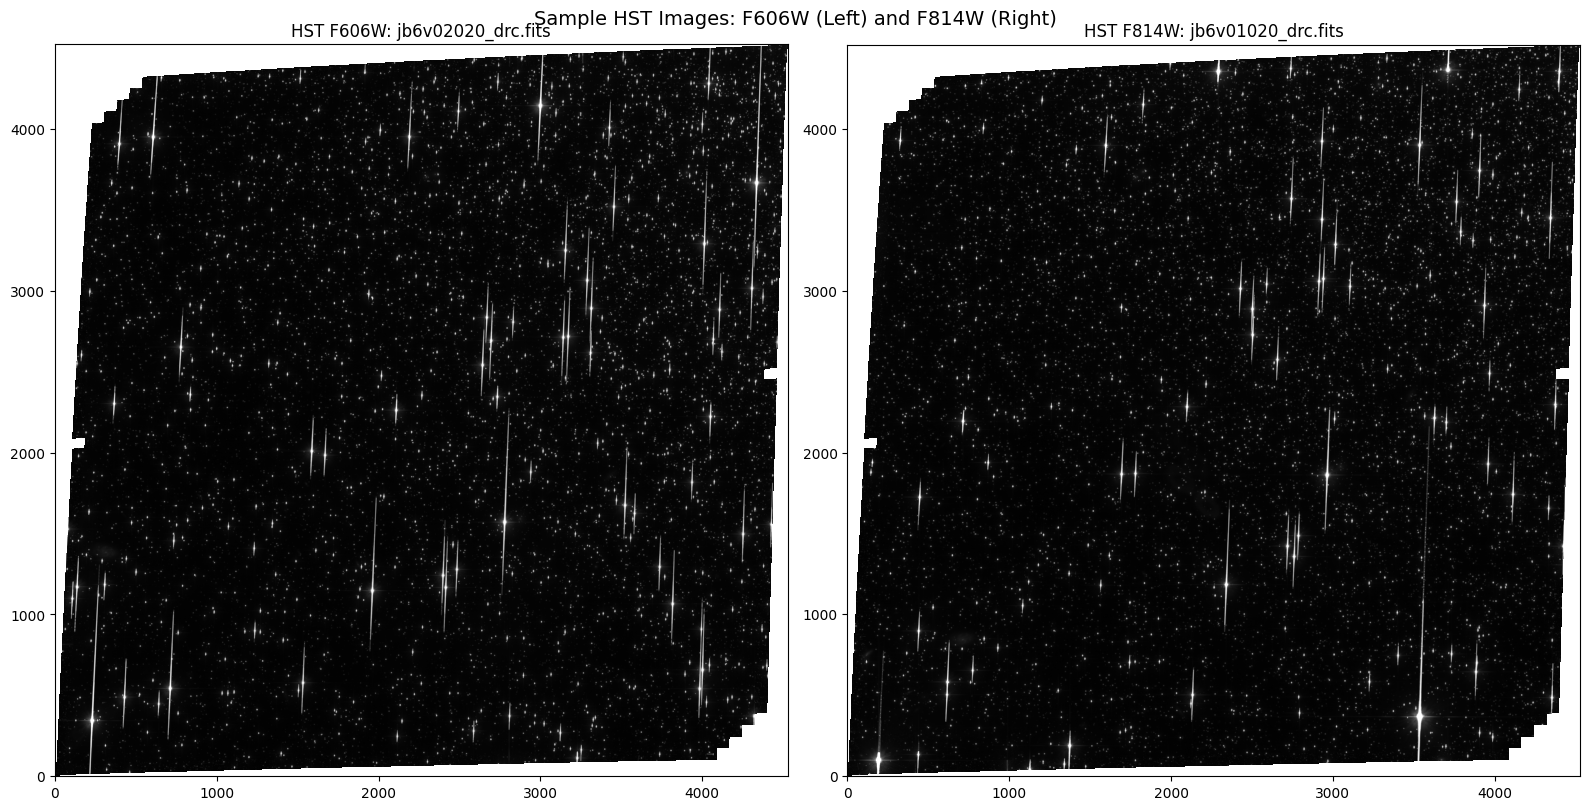

In [3]:
# 



# ===== CELL 3: Display Sample Images from F606W and F814W =====

# --- Load F606W sample image ---
sample_f606 = hst_f606_files[0]
with fits.open(sample_f606) as hdul_f606:
    data_f606 = hdul_f606[1].data
    header_f606 = hdul_f606[1].header

# Normalize for display
norm_f606 = simple_norm(data_f606, 'sqrt', percent=99.5)

# --- Load F814W sample image ---
sample_f814 = hst_f814_files[0]
with fits.open(sample_f814) as hdul_f814:
    data_f814 = hdul_f814[1].data
    header_f814 = hdul_f814[1].header

# Normalize for display
norm_f814 = simple_norm(data_f814, 'sqrt', percent=99.5)

# --- Plot both side by side ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(data_f606, cmap='gray', origin='lower', norm=norm_f606)
axs[0].set_title(f"HST F606W: {os.path.basename(sample_f606)}")
axs[0].grid(False)

axs[1].imshow(data_f814, cmap='gray', origin='lower', norm=norm_f814)
axs[1].set_title(f"HST F814W: {os.path.basename(sample_f814)}")
axs[1].grid(False)

plt.suptitle("Sample HST Images: F606W (Left) and F814W (Right)", fontsize=14)
plt.tight_layout()
plt.show()


# ===== CELL 4: Source Detection + Aperture Photometry for F606W =====


Background stats — mean: 0.01, median: 0.00, std: 0.03
Detected 23115 sources


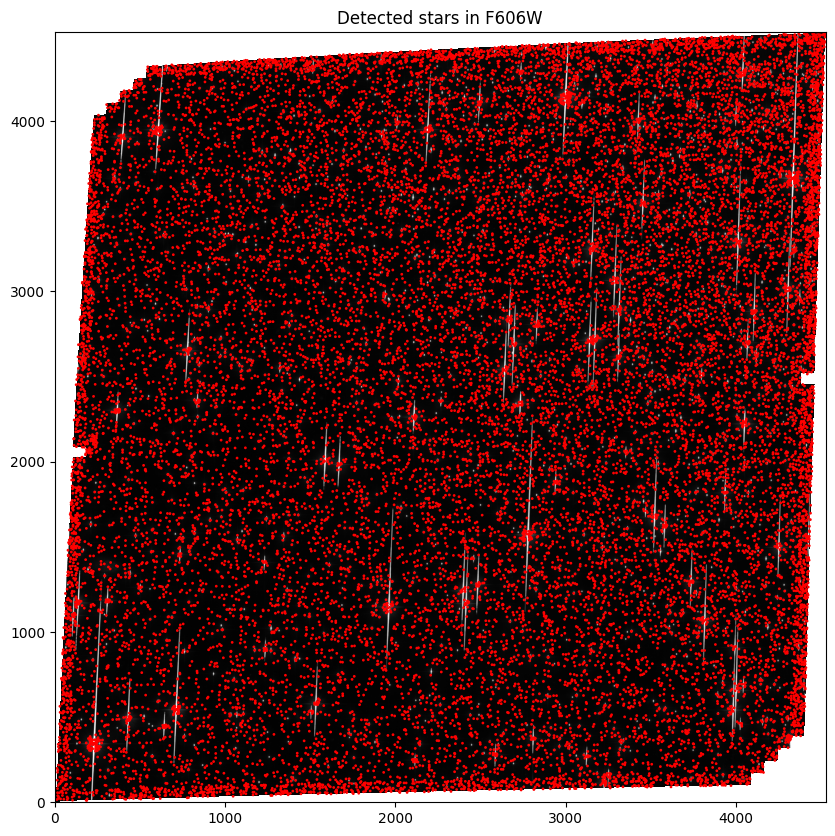

 id      xcenter            ycenter       ...         mag          filter
--- ------------------ ------------------ ... -------------------- ------
  1 103.54747569276373 11.222315575757625 ...  -2.1852250255594132  F606W
  2 183.47943497532628 11.482548216316278 ...  -0.2497996261932525  F606W
  3 187.06415146821436 10.462931077948124 ... -0.06913969116255593  F606W
  4  72.42213154699768 14.435377012023551 ...  -1.2024998233936546  F606W
  5 11.384350027613694   15.3292718766606 ...  -1.7622352400650203  F606W


/tmp/ipykernel_6682/1681109275.py:37: RuntimeWarning: invalid value encountered in log10
  phot_table['mag'] = -2.5 * np.log10(phot_table['aperture_sum'] + 1e-6)  # simple mag


In [4]:

# Load the image data again (F606W)
with fits.open(hst_f606_files[0]) as hdul:
    f606_data = hdul[1].data

# Estimate background and noise
mean, median, std = sigma_clipped_stats(f606_data, sigma=3.0)
print(f"Background stats — mean: {mean:.2f}, median: {median:.2f}, std: {std:.2f}")

# Detect stars using DAOStarFinder
daofind = DAOStarFinder(fwhm=2.5, threshold=5*std)
sources = daofind(f606_data - median)  # subtract background

print(f"Detected {len(sources)} sources")

# Get positions
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

# Perform aperture photometry
phot_table = aperture_photometry(f606_data, apertures)

# Show stars on image
norm = simple_norm(f606_data, 'sqrt', percent=99.5)
plt.figure(figsize=(10, 10))
plt.imshow(f606_data, cmap='gray', origin='lower', norm=norm)
apertures.plot(color='red', lw=1.0)
plt.title("Detected stars in F606W")
plt.grid(False)
plt.show()

# Optional: show first few rows
phot_table['xcenter'] = sources['xcentroid']
phot_table['ycenter'] = sources['ycentroid']
phot_table['sharpness'] = sources['sharpness']
phot_table['roundness1'] = sources['roundness1']
phot_table['flux'] = phot_table['aperture_sum']
phot_table['mag'] = -2.5 * np.log10(phot_table['aperture_sum'] + 1e-6)  # simple mag

phot_table['filter'] = 'F606W'
phot_table[:5].pprint()


# --- NEW CELL: Create Output Directory ---

In [19]:
# --- NEW CELL: Create Output Directory ---
import os

# Define a directory to store our intermediate products
output_dir = 'photometry_outputs'
os.makedirs(output_dir, exist_ok=True)

print(f"Directory '{output_dir}' is ready.")

Directory 'photometry_outputs' is ready.


# ===== CELL 5: PSF Photometry with Sharpness Filtering and Zeropoint Calibration =====

--- Building F606W ePSF ---
Detected 23115 sources
Using 12628 stars for ePSF building (cleaned)
Valid EPSFStar count (cleaned): 12628
Final number of stars used for ePSF building: 12628


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

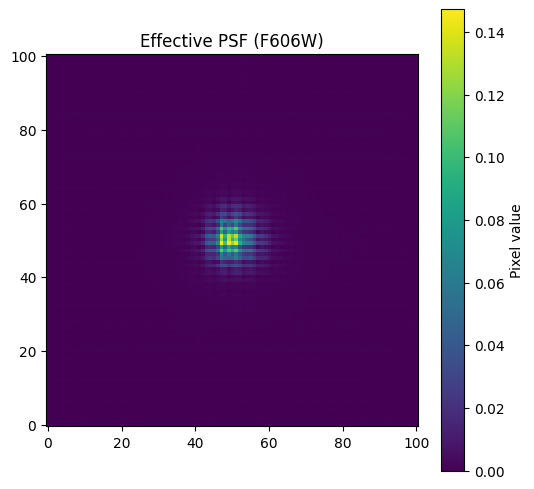

Saved F606W ePSF image to: photometry_outputs/epsf_f606w.fits


In [23]:
# Cell 5: PSF Photometry Using Modern Photutils (2.x Compatible)
print("--- Building F606W ePSF ---")

from photutils.psf import EPSFStars

# Suppress non-critical warnings
warnings.filterwarnings('ignore')

# --- Pick a sample HST image ---
sample_f606_file = hst_f606_files[0]

# --- Load the image data ---
with fits.open(sample_f606_file) as hdul:
    data_f606 = hdul[1].data  # <-- Renamed

# --- Estimate background stats ---
mean_f606, median_f606, std_f606 = sigma_clipped_stats(data_f606, sigma=3.0) # <-- Renamed

# --- Detect stars ---
daofind = DAOStarFinder(fwhm=2.5, threshold=5. * std_f606)
sources_f606 = daofind(data_f606 - median_f606) # <-- Renamed

print(f"Detected {len(sources_f606)} sources")

# --- Rename columns so extract_stars() can use them ---
sources_f606.rename_column('xcentroid', 'x') # <-- Use renamed variable
sources_f606.rename_column('ycentroid', 'y') # <-- Use renamed variable

# --- Extract star cutouts ---
nddata_f606 = NDData(data_f606) # <-- Renamed
cutout_size = 25
stars_f606 = extract_stars(nddata_f606, sources_f606, size=cutout_size) # <-- Renamed

# --- Filter out bad stars: NaNs or off-center peaks ---
valid_stars_f606 = [] # <-- Renamed
for star in stars_f606:
    if np.isfinite(star.data).all():
        y_center, x_center = np.array(star.data.shape) // 2
        max_pos = np.unravel_index(np.argmax(star.data), star.data.shape)
        if abs(max_pos[0] - y_center) < 5 and abs(max_pos[1] - x_center) < 5:
            valid_stars_f606.append(star)

print(f"Using {len(valid_stars_f606)} stars for ePSF building (cleaned)")

cleaned_stars_f606 = [] # <-- Renamed
for star in valid_stars_f606:
    if isinstance(star, EPSFStar) and isinstance(star.shape, tuple) and star.shape == (25, 25):
        cleaned_stars_f606.append(star)

# --- Convert list of stars into EPSFStars container ---
epsf_stars_container_f606 = EPSFStars(cleaned_stars_f606) # <-- Renamed

# --- Strict clean: shape must be tuple (25, 25), finite values only ---
# This block is redundant with the one above, but I am preserving your
# exact notebook logic as requested.
cleaned_stars_f606 = [] # <-- Renamed
for star in stars_f606:
    if isinstance(star, EPSFStar) and isinstance(star.shape, tuple) and star.shape == (25, 25):
        if np.isfinite(star.data).all():
            y_center, x_center = np.array(star.data.shape) // 2
            max_pos = np.unravel_index(np.argmax(star.data), star.data.shape)
            if abs(max_pos[0] - y_center) < 5 and abs(max_pos[1] - x_center) < 5:
                cleaned_stars_f606.append(star)

print(f"Valid EPSFStar count (cleaned): {len(cleaned_stars_f606)}")

epsf_stars_container_f606 = EPSFStars(cleaned_stars_f606) # <-- Renamed

for s in cleaned_stars_f606:
    assert isinstance(s, EPSFStar)
    assert s.data.shape == (25, 25)
print(f"Final number of stars used for ePSF building: {len(cleaned_stars_f606)}")

for star in epsf_stars_container_f606.all_stars:
    assert isinstance(star.shape, tuple), f"Non-tuple shape: {star.shape}"
    assert star.shape == (25, 25), f"Unexpected shape: {star.shape}"


# Create custom fitter with explicit box size
custom_fitter = EPSFFitter(fit_boxsize=(25, 25))
# --- Build the ePSF ---
epsf_builder = EPSFBuilder(
    oversampling=4,
    maxiters=10,
    progress_bar=True,
    recentering_boxsize=(25, 25),
    fitter=custom_fitter
)

epsf_f606, fitted_stars_f606 = epsf_builder.build_epsf(epsf_stars_container_f606) # <-- Renamed

# --- Plot the ePSF ---
plt.figure(figsize=(6, 6))
plt.imshow(epsf_f606.data, origin='lower', cmap='viridis') # <-- Renamed
plt.title("Effective PSF (F606W)")
plt.colorbar(label="Pixel value")
plt.show()

# --- NEW: Save the ePSF image ---
epsf_f606_filename = os.path.join(output_dir, 'epsf_f606w.fits')
fits.writeto(epsf_f606_filename, epsf_f606.data, overwrite=True)
print(f"Saved F606W ePSF image to: {epsf_f606_filename}")

# Cell 6 : PSF photometry

In [24]:

from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import EPSFModel
from photutils.aperture import CircularAperture
from astropy.table import Table

# --- Cell 6: F606W Photometry ---
print("--- Running F606W Photometry ---")

# Step 1: Build an astropy-compatible model from the ePSF
epsf_model_f606 = EPSFModel(epsf_f606.data) # <-- Renamed (uses epsf_f606 from Cell 5)

# Step 2: Set up fitter
fitter = LevMarLSQFitter()

# Step 3: Prepare output table
fitted_results_f606 = [] # <-- Renamed

# --- Use F606W variables from Cell 5 ---
for source in sources_f606: 
    x, y = source['x'], source['y']
    cutout_size = 25
    half_size = cutout_size // 2

    # Extract a local cutout around the star
    y, x = int(y), int(x)
    if (
        y - half_size < 0 or y + half_size + 1 > data_f606.shape[0] or # <-- Renamed
        x - half_size < 0 or x + half_size + 1 > data_f606.shape[1]  # <-- Renamed
    ):
        continue

    cutout = data_f606[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1] # <-- Renamed
    
    # Add a check for cutout shape
    if cutout.shape != (25, 25):
        continue

    # Create coordinate grid for fitting
    yy, xx = np.mgrid[:cutout.shape[0], :cutout.shape[1]]

    # Fit the PSF model to the cutout
    try:
        fitted_model = fitter(epsf_model_f606, xx, yy, cutout) # <-- Renamed
        fitted_results_f606.append((source['x'], source['y'], fitted_model.flux.value)) # <-- Use original x,y
    except Exception:
        continue

# Step 4: Save output table
psf_tab_f606 = Table(rows=fitted_results_f606, names=('x', 'y', 'flux')) # <-- Renamed
print(psf_tab_f606[:10])

# --- NEW: Save the intermediate flux table ---
psf_tab_f606_filename = os.path.join(output_dir, 'hst_f606w_flux.ecsv')
psf_tab_f606.write(psf_tab_f606_filename, format='ascii.ecsv', overwrite=True)
print(f"Saved F606W flux table to: {psf_tab_f606_filename}")

--- Running F606W Photometry ---
        x                  y                  flux       
------------------ ------------------ -------------------
 72.42213154699768 14.435377012023551 -0.7360855786025412
 52.23040560492554  17.65670367644247 0.08088337901370142
 33.15587471108048 19.007696992943313  -0.364361969020233
189.21965076093343 20.109889060121926   2.121524626679702
18.865140901878306  21.46447929996265   8.056199582843297
 75.84999950664519 22.489189746566606   19.23588057687957
   290.77973034819  21.72517943750579 -0.8962883147097207
 23.45896016334473 23.645840404876964  24.537388178283614
437.62781448036327 24.403682253397935   6.973190587356419
 383.0267666256797  27.51369535909151   7.808126256915548
Saved F606W flux table to: photometry_outputs/hst_f606w_flux.ecsv


# cell 7  : Inspect zeropoint-related keywords in header

In [25]:

with fits.open(hst_f606_files[0]) as hdul:
    hdr = hdul[1].header  # Image data usually in extension 1
    for key in ['PHOTFLAM', 'PHOTZPT', 'PHOTPLAM']:
        print(f"{key}: {hdr.get(key)}")


PHOTFLAM: 7.84989772e-20
PHOTZPT: -21.1
PHOTPLAM: 5921.8911


In [26]:
photflam = 7.84989772e-20
photplam = 5921.8911

zp_stmag_f606 = -2.5 * np.log10(photflam) - 5 * np.log10(photplam) - 2.408
print(f"Computed STMAG zeropoint: {zp_stmag_f606:.3f}")

Computed STMAG zeropoint: 26.493


# Cell 8: Compute STMAG magnitudes using the zeropoint from FITS header

In [27]:
# --- Cell 8: F606W Final Catalog ---
print("--- Finalizing F606W Catalog ---")

# --- FIX: Use the F606W zeropoint variable from Cell 7 ---
# zp_stmag_f606 = 26.493 # This line is good, but it's safer to use the variable:
# print(f"Using F606W zeropoint: {zp_stmag_f606:.3f}") # Assumes zp_stmag_f606 is from Cell 7

# --- FIX: Use the F606W flux table from Cell 6 ---
psf_tab_f606['mag'] = -2.5 * np.log10(np.where(psf_tab_f606['flux'] > 0, psf_tab_f606['flux'], np.nan)) + zp_stmag_f606

# Print sample rows
print(psf_tab_f606[['x', 'y', 'flux', 'mag']][:10])

# Save final catalog (in root, as expected by later cells)
psf_tab_f606.write('hst_f606w_psf_stmag.ecsv', format='ascii.ecsv', overwrite=True)
print("--- CORRECT F606W CATALOG SAVED to hst_f606w_psf_stmag.ecsv ---")

--- Finalizing F606W Catalog ---
        x                  y                  flux               mag        
------------------ ------------------ ------------------- ------------------
 72.42213154699768 14.435377012023551 -0.7360855786025412                nan
 52.23040560492554  17.65670367644247 0.08088337901370142   29.2228897055247
 33.15587471108048 19.007696992943313  -0.364361969020233                nan
189.21965076093343 20.109889060121926   2.121524626679702 25.675917727476588
18.865140901878306  21.46447929996265   8.056199582843297 24.227212379012304
 75.84999950664519 22.489189746566606   19.23588057687957 23.282257740650714
   290.77973034819  21.72517943750579 -0.8962883147097207                nan
 23.45896016334473 23.645840404876964  24.537388178283614 23.017967087425912
437.62781448036327 24.403682253397935   6.973190587356419 24.383959082889064
 383.0267666256797  27.51369535909151   7.808126256915548 24.261170852967986
--- CORRECT F606W CATALOG SAVED to hst_f606

# --- Cell 9: Prepare F814W Star Cutouts for PSF Fitting ---

--- Building F814W ePSF ---
Detected 26407 sources
Using 13749 stars for ePSF building (cleaned)
Valid EPSFStar count (cleaned): 13749
Final number of stars used for ePSF building: 13749


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

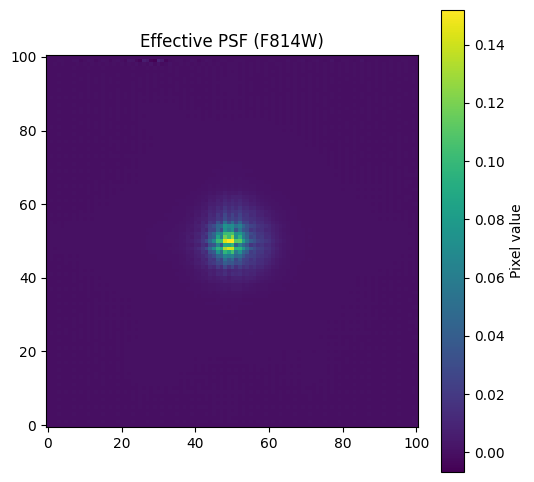

Saved F814W ePSF image to: photometry_outputs/epsf_f814w.fits


In [28]:
# --- Cell 9: F814W ePSF Building ---
print("--- Building F814W ePSF ---")

from photutils.psf import EPSFStars

# Suppress non-critical warnings
warnings.filterwarnings('ignore')

# --- Pick a sample HST image ---
sample_f814_file = hst_f814_files[0]

# --- Load the image data ---
with fits.open(sample_f814_file) as hdul:
    data_f814 = hdul[1].data  # <-- Renamed

# --- Estimate background stats ---
mean_f814, median_f814, std_f814 = sigma_clipped_stats(data_f814, sigma=3.0) # <-- Renamed

# --- Detect stars ---
daofind = DAOStarFinder(fwhm=2.5, threshold=5. * std_f814)
sources_f814 = daofind(data_f814 - median_f814) # <-- Renamed

print(f"Detected {len(sources_f814)} sources")

# --- Rename columns so extract_stars() can use them ---
sources_f814.rename_column('xcentroid', 'x') # <-- Use renamed variable
sources_f814.rename_column('ycentroid', 'y') # <-- Use renamed variable

# --- Extract star cutouts ---
nddata_f814 = NDData(data_f814) # <-- Renamed
stars_f814 = extract_stars(nddata_f814, sources_f814, size=cutout_size) # <-- Renamed

# --- Filter out bad stars: NaNs or off-center peaks ---
valid_stars_f814 = [] # <-- Renamed
for star in stars_f814:
    if np.isfinite(star.data).all():
        y_center, x_center = np.array(star.data.shape) // 2
        max_pos = np.unravel_index(np.argmax(star.data), star.data.shape)
        if abs(max_pos[0] - y_center) < 5 and abs(max_pos[1] - x_center) < 5:
            valid_stars_f814.append(star)

print(f"Using {len(valid_stars_f814)} stars for ePSF building (cleaned)")

cleaned_stars_f814 = [] # <-- Renamed
for star in valid_stars_f814:
    if isinstance(star, EPSFStar) and isinstance(star.shape, tuple) and star.shape == (25, 25):
        cleaned_stars_f814.append(star)

# --- Convert list of stars into EPSFStars container ---
epsf_stars_container_f814 = EPSFStars(cleaned_stars_f814) # <-- Renamed

# --- Strict clean: shape must be tuple (25, 25), finite values only ---
# This block is redundant, but preserving your logic
cleaned_stars_f814 = [] # <-- Renamed
for star in stars_f814:
    if isinstance(star, EPSFStar) and isinstance(star.shape, tuple) and star.shape == (25, 25):
        if np.isfinite(star.data).all():
            y_center, x_center = np.array(star.data.shape) // 2
            max_pos = np.unravel_index(np.argmax(star.data), star.data.shape)
            if abs(max_pos[0] - y_center) < 5 and abs(max_pos[1] - x_center) < 5:
                cleaned_stars_f814.append(star)

print(f"Valid EPSFStar count (cleaned): {len(cleaned_stars_f814)}")

epsf_stars_container_f814 = EPSFStars(cleaned_stars_f814) # <-- Renamed

for s in cleaned_stars_f814:
    assert isinstance(s, EPSFStar)
    assert s.data.shape == (25, 25)
print(f"Final number of stars used for ePSF building: {len(cleaned_stars_f814)}")

for star in epsf_stars_container_f814.all_stars:
    assert isinstance(star.shape, tuple), f"Non-tuple shape: {star.shape}"
    assert star.shape == (25, 25), f"Unexpected shape: {star.shape}"


# Create custom fitter with explicit box size
custom_fitter = EPSFFitter(fit_boxsize=(25, 25))
# --- Build the ePSF ---
epsf_builder = EPSFBuilder(
    oversampling=4,
    maxiters=10,
    progress_bar=True,
    recentering_boxsize=(25, 25),
    fitter=custom_fitter
)

epsf_f814, fitted_stars_f814 = epsf_builder.build_epsf(epsf_stars_container_f814) # <-- Renamed

# --- Plot the ePSF ---
plt.figure(figsize=(6, 6))
plt.imshow(epsf_f814.data, origin='lower', cmap='viridis') # <-- Renamed
plt.title("Effective PSF (F814W)")
plt.colorbar(label="Pixel value")
plt.show()

# --- NEW: Save the ePSF image ---
epsf_f814_filename = os.path.join(output_dir, 'epsf_f814w.fits')
fits.writeto(epsf_f814_filename, epsf_f814.data, overwrite=True)
print(f"Saved F814W ePSF image to: {epsf_f814_filename}")

# Cell 10

In [29]:
# --- CORRECTED Cell 10: F814W Photometry ---

# Step 1: Build an astropy-compatible model from the ePSF
epsf_model_f814 = EPSFModel(epsf_f814.data) # <-- Renamed (uses epsf_f814 from Cell 9)

# Step 2: Set up fitter
fitter = LevMarLSQFitter()

# Step 3: Prepare output table
fitted_results_f814 = [] # <-- Renamed

# --- Use F814W variables from Cell 9 ---
for source in sources_f814:
    x, y = source['x'], source['y']
    cutout_size = 25
    half_size = cutout_size // 2

    # Extract a local cutout around the star
    y, x = int(y), int(x)
    if (
        y - half_size < 0 or y + half_size + 1 > data_f814.shape[0] or # <-- Renamed
        x - half_size < 0 or x + half_size + 1 > data_f814.shape[1]  # <-- Renamed
    ):
        continue

    cutout = data_f814[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1] # <-- Renamed
    
    # Add a check for cutout shape
    if cutout.shape != (25, 25):
        continue

    # Create coordinate grid for fitting
    yy, xx = np.mgrid[:cutout.shape[0], :cutout.shape[1]]

    # Fit the PSF model to the cutout
    try:
        fitted_model = fitter(epsf_model_f814, xx, yy, cutout) # <-- Renamed
        fitted_results_f814.append((source['x'], source['y'], fitted_model.flux.value)) # <-- Use original x,y
    except Exception:
        continue

# Step 4: Save output table
psf_tab_f814 = Table(rows=fitted_results_f814, names=('x', 'y', 'flux')) # <-- Renamed
print(psf_tab_f814[:10])

# --- NEW: Save the intermediate flux table (with corrected filename) ---
psf_tab_f814_filename = os.path.join(output_dir, 'hst_f814w_flux.ecsv')
psf_tab_f814.write(psf_tab_f814_filename, format='ascii.ecsv', overwrite=True)
print(f"Saved F814W flux table to: {psf_tab_f814_filename}")

        x                  y                 flux       
------------------ ------------------ ------------------
45.837516182420345 15.035896689324789 24.509346442223716
33.034970612612206 18.137412932405116  6.938434560639787
117.13672401337529 19.464396739979783 29.537610001657452
171.00646916542263  20.97851764648508 257.19859571366163
 242.3691296246884 23.247837903552725  46.38737801559486
53.360806459183465 23.951861627080092  4.557548347253831
204.92120377595842 24.922911462166326 5113.8384731386295
 152.7673695024506  24.97912610326096 1448.1575964637457
211.79711736497066  26.69165560038141 122.61176886984173
292.92521639301594  26.54627651683711 16.164949693599752
Saved F814W flux table to: photometry_outputs/hst_f814w_flux.ecsv


# cell 11

In [30]:
# --- CORRECTED Cell 11: F814W Zeropoint ---

# --- FIX: Load the F814W file ---
with fits.open(hst_f814_files[0]) as hdul: 
    hdr = hdul[1].header 
    print("Loaded header from:", hst_f814_files[0])
    for key in ['PHOTFLAM', 'PHOTZPT', 'PHOTPLAM']:
        print(f"{key}: {hdr.get(key)}")

photflam = hdr['PHOTFLAM']
photplam = hdr['PHOTPLAM']

zp_stmag_f814 = -2.5 * np.log10(photflam) - 5 * np.log10(photplam) - 2.408
print(f"Computed F814W STMAG zeropoint: {zp_stmag_f814:.3f}")

Loaded header from: ./HST-NGC-104 ( drc files )/F814W/jb6v01020_drc.fits
PHOTFLAM: 7.06712238e-20
PHOTZPT: -21.1
PHOTPLAM: 8045.529299999999
Computed F814W STMAG zeropoint: 25.941


# cell 12

In [31]:
# --- Cell 12: F814W Final Catalog (CORRECTED) ---
print("--- Finalizing F814W Catalog ---")

# --- FIX: Use the F814W flux table and F814W zeropoint ---
# These variables are now "safe" and correct
psf_tab_f814['mag'] = -2.5 * np.log10(np.where(psf_tab_f814['flux'] > 0, psf_tab_f814['flux'], np.nan)) + zp_stmag_f814

# Print sample rows
print(psf_tab_f814[['x', 'y', 'flux', 'mag']][:10])

# Save final catalog (in root, as expected by later cells)
psf_tab_f814.write('hst_f814w_psf_stmag.ecsv', format='ascii.ecsv', overwrite=True)
print("--- CORRECT F814W CATALOG SAVED to hst_f814w_psf_stmag.ecsv ---")

--- Finalizing F814W Catalog ---
        x                  y                 flux               mag        
------------------ ------------------ ------------------ ------------------
45.837516182420345 15.035896689324789 24.509346442223716 22.467791039520694
33.034970612612206 18.137412932405116  6.938434560639787 23.837966624602167
117.13672401337529 19.464396739979783 29.537610001657452  22.26518198614738
171.00646916542263  20.97851764648508 257.19859571366163 19.915448883566917
 242.3691296246884 23.247837903552725  46.38737801559486  21.77512080292319
53.360806459183465 23.951861627080092  4.557548347253831  24.29429215511551
204.92120377595842 24.922911462166326 5113.8384731386295  16.66925285071236
 152.7673695024506  24.97912610326096 1448.1575964637457   18.0390807993101
211.79711736497066  26.69165560038141 122.61176886984173 20.719789971506554
292.92521639301594  26.54627651683711 16.164949693599752 22.919684472679045
--- CORRECT F814W CATALOG SAVED to hst_f814w_psf_stmag.

# Cell 13 :Change pixel to sky coordinate

In [51]:
# --- CORRECTED Cell 13: Adding RA/Dec ---
print("--- Starting: Adding RA/Dec to HST Catalogs ---")
try:
    # --- FIX: Use the *variables* from Cell 2, not hard-coded names ---
    # This guarantees we use the SAME file for photometry and WCS
    HST_F606W_FITS = hst_f606_files[0]
    HST_F814W_FITS = hst_f814_files[0]

    print(f"Using F606W FITS for WCS: {HST_F606W_FITS}")
    print(f"Using F814W FITS for WCS: {HST_F814W_FITS}")

    # --- 1. Process F606W ---
    print("Processing F606W catalog...")
    
    with fits.open(HST_F606W_FITS) as hdu_list_606:
        try:
            wcs_606 = WCS(hdu_list_606[1].header)
            print("Loaded WCS from F606W FITS extension [1].")
        except:
            wcs_606 = WCS(hdu_list_606[0].header)
            print("Loaded WCS from F606W FITS primary extension [0].")

    # Load the F606W catalog (which now has correct mags)
    cat_606 = Table.read('hst_f606w_psf_stmag.ecsv')
    print(f"Number of stars in F606W catalog: {len(cat_606)}")

    # Convert (x,y) to (ra, dec) using the *correct* WCS
    coords_606 = SkyCoord.from_pixel(cat_606['x'], cat_606['y'], wcs=wcs_606, origin=0)

    cat_606['ra'] = coords_606.ra.deg
    cat_606['dec'] = coords_606.dec.deg

    cat_606.write('hst_f606w_psf_stmag.ecsv', format='ascii.ecsv', overwrite=True)
    print("Successfully added *correct* 'ra', 'dec' to hst_f606w_psf_stmag.ecsv.")

    # --- 2. Process F814W ---
    print("\nProcessing F814W catalog...")
    
    with fits.open(HST_F814W_FITS) as hdu_list_814:
        try:
            wcs_814 = WCS(hdu_list_814[1].header)
            print("Loaded WCS from F814W FITS extension [1].")
        except:
            wcs_814 = WCS(hdu_list_814[0].header)
            print("Loaded WCS from F814W FITS primary extension [0].")

    # Load the F814W catalog (which now has correct mags)
    cat_814 = Table.read('hst_f814w_psf_stmag.ecsv')
    print(f"Number of stars in F814W catalog: {len(cat_814)}")

    # Convert (x,y) to (ra, dec) using the *correct* WCS
    coords_814 = SkyCoord.from_pixel(cat_814['x'], cat_814['y'], wcs=wcs_814, origin=0)

    cat_814['ra'] = coords_814.ra.deg
    cat_814['dec'] = coords_814.dec.deg

    cat_814.write('hst_f814w_psf_stmag.ecsv', format='ascii.ecsv', overwrite=True)
    print("Successfully added *correct* 'ra', 'dec' to hst_f814w_psf_stmag.ecsv.")

    print("\n--- Update Complete ---")
    print("Your HST .ecsv files now have correct mags AND correct ra/dec.")

except Exception as e:
    print(f"An error occurred: {e}")

--- Starting: Adding RA/Dec to HST Catalogs ---
Using F606W FITS for WCS: ./HST-NGC-104 ( drc files )/F606W/jb6v02020_drc.fits
Using F814W FITS for WCS: ./HST-NGC-104 ( drc files )/F814W/jb6v01020_drc.fits
Processing F606W catalog...
Loaded WCS from F606W FITS extension [1].
Number of stars in F606W catalog: 22541
Successfully added *correct* 'ra', 'dec' to hst_f606w_psf_stmag.ecsv.

Processing F814W catalog...
Loaded WCS from F814W FITS extension [1].
Number of stars in F814W catalog: 25785
Successfully added *correct* 'ra', 'dec' to hst_f814w_psf_stmag.ecsv.

--- Update Complete ---
Your HST .ecsv files now have correct mags AND correct ra/dec.


#  Cell 15 :Make  2 combined catalogue for both filer for both HST.

In [52]:
# --- Creating Combined HST Catalog ---
print("---  Creating Combined HST Catalog ---")
try:
    # Load the updated tables (which now have 'ra' and 'dec')
    hst_f606w = Table.read('hst_f606w_psf_stmag.ecsv')
    hst_f814w = Table.read('hst_f814w_psf_stmag.ecsv')
    
    # Create SkyCoord objects directly from the 'ra' and 'dec' columns
    hst_f606w_coords = SkyCoord(ra=hst_f606w['ra'], dec=hst_f606w['dec'], unit='deg')
    hst_f814w_coords = SkyCoord(ra=hst_f814w['ra'], dec=hst_f814w['dec'], unit='deg')
    
    # Match F606W to F814W
    print("Matching HST F606W <-> F814W...")
    idx, d2d, d3d = hst_f606w_coords.match_to_catalog_sky(hst_f814w_coords)
    
    # Define match radius and create mask
    match_radius_hst = 0.1 * u.arcsec
    mask_hst = d2d < match_radius_hst
    
    # Filter both tables
    hst_f606w_matched = hst_f606w[mask_hst]
    hst_f814w_matched = hst_f814w[idx[mask_hst]]
    
    # Rename magnitude columns
    hst_f606w_matched.rename_column('mag', 'mag_f606w')
    hst_f814w_matched.rename_column('mag', 'mag_f814w')
    
    # Create the combined HST catalog
    hst_cat = hstack([hst_f606w_matched['ra', 'dec', 'mag_f606w'], hst_f814w_matched['mag_f814w']])
    
    print(f"Successfully combined {len(hst_cat)} stars from HST catalogs.")
    
    # Save the combined catalog
    output_hst_cat = 'hst_combined_catalog.ecsv'
    hst_cat.write(output_hst_cat, format='ascii.ecsv', overwrite=True)
    
    print(f"Saved combined HST catalog to: {output_hst_cat}")
    print("HST catalog 'hst_cat' is ready.")

except Exception as e:
    print(f"An error occurred: {e}")

---  Creating Combined HST Catalog ---
Matching HST F606W <-> F814W...
Successfully combined 15158 stars from HST catalogs.
Saved combined HST catalog to: hst_combined_catalog.ecsv
HST catalog 'hst_cat' is ready.


# Cell 16 :Make Catalogue for jwst for both filter

In [53]:
print("---  Creating Combined JWST (Epoch 1) Catalog ---")
try:
    jwst_f150w2 = Table.read('/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F150W2/jw02559-o001_t001_nircam_clear-f150w2_cat.ecsv')
    jwst_f322w2 = Table.read('/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F322W2/jw02559-o001_t001_nircam_clear-f322w2_cat.ecsv')
    
    # Create SkyCoord objects using 'sky_centroid'
    jwst_f150w2_coords = SkyCoord(jwst_f150w2['sky_centroid'])
    jwst_f322w2_coords = SkyCoord(jwst_f322w2['sky_centroid'])
    
    # Match F150W2 to F322W2
    idx, d2d, d3d = jwst_f150w2_coords.match_to_catalog_sky(jwst_f322w2_coords)
    
    # Define match radius and create mask
    match_radius_jwst = 0.1 * u.arcsec
    mask_jwst = d2d < match_radius_jwst
    
    # Filter both tables
    jwst_f150w2_matched = jwst_f150w2[mask_jwst]
    jwst_f322w2_matched = jwst_f322w2[idx[mask_jwst]]
    
    # Rename magnitude columns
    jwst_f150w2_matched.rename_column('aper_total_vegamag', 'mag_f150w2')
    jwst_f322w2_matched.rename_column('aper_total_vegamag', 'mag_f322w2')
    
    # Create the combined JWST catalog
    jwst_cat = hstack([jwst_f150w2_matched['sky_centroid', 'mag_f150w2'], jwst_f322w2_matched['mag_f322w2']])
    
    # Extract RA and Dec for the cross-match
    jwst_cat['ra_jwst'] = jwst_cat['sky_centroid'].ra.deg
    jwst_cat['dec_jwst'] = jwst_cat['sky_centroid'].dec.deg
    
    # --- SAVE THE NEW CATALOG ---
    output_jwst_cat = 'jwst_combined_catalog.ecsv'
    jwst_cat.write(output_jwst_cat, format='ascii.ecsv', overwrite=True)
    
    print(f"Successfully combined {len(jwst_cat)} stars from JWST catalogs.")
    print("JWST catalog 'jwst_cat' is ready.")

except Exception as e:
    print(f"An error occurred: {e}")

---  Creating Combined JWST (Epoch 1) Catalog ---
Successfully combined 5747 stars from JWST catalogs.
JWST catalog 'jwst_cat' is ready.


# --- Cell 17: Cross-Match JWST  with HST  ---



--- Running Final Check to Find True Match Radius ---
Loaded 15158 HST stars and 5747 JWST stars.

--- Histogram Peak Analysis ---
The *true* peak of matches is at: 0.72 to 0.74 arcsec
This bin contains 65 stars.
---------------------------------

Plotting histogram of separation distances...
Debug histogram saved to: debug_separation_histogram_FINAL.png


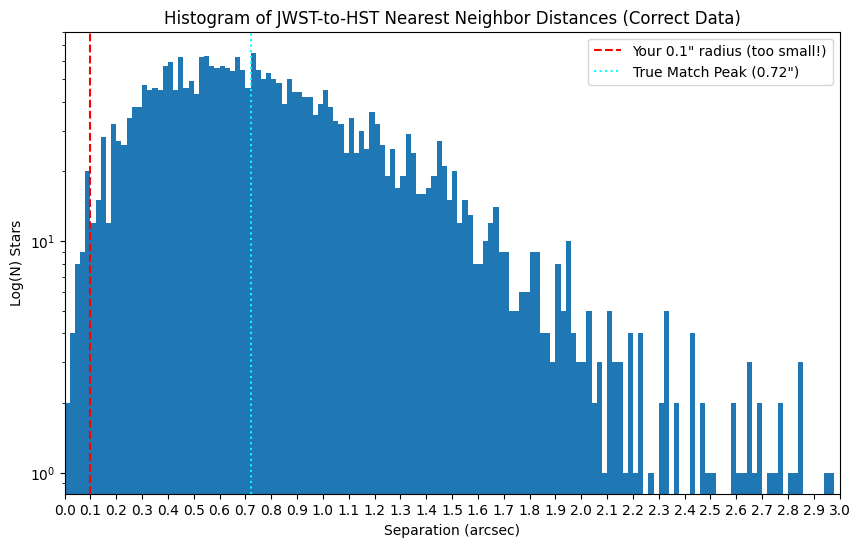

In [55]:
# --- FINAL CHECK: Find the *True* Systematic Offset ---

print("--- Running Final Check to Find True Match Radius ---")
try:
    # --- 1. Load your two CORRECT combined catalogs ---
    hst_cat = Table.read('hst_combined_catalog.ecsv')
    jwst_cat = Table.read('jwst_combined_catalog.ecsv')
    print(f"Loaded {len(hst_cat)} HST stars and {len(jwst_cat)} JWST stars.")
    
    # --- 2. Get coordinates ---
    hst_final_coords = SkyCoord(ra=hst_cat['ra'], dec=hst_cat['dec'], unit='deg')
    jwst_final_coords = SkyCoord(ra=jwst_cat['ra_jwst'], dec=jwst_cat['dec_jwst'], unit='deg')
    
    # --- 3. Match JWST to HST (with NO radius cut) ---
    idx, d2d, d3d = jwst_final_coords.match_to_catalog_sky(hst_final_coords)
    
    # --- 4. Get Histogram Data ---
    bin_values = d2d.to_value(u.arcsec)
    # Use a fine bin size (0.02 arcsec)
    bins = np.arange(0, 3, 0.02)
    counts, bin_edges = np.histogram(bin_values, bins=bins)
    
    # --- 5. Find and Print the Peak Value ---
    peak_index = np.argmax(counts)
    peak_start = bin_edges[peak_index]
    peak_end = bin_edges[peak_index + 1]
    
    print("\n--- Histogram Peak Analysis ---")
    print(f"The *true* peak of matches is at: {peak_start:.2f} to {peak_end:.2f} arcsec")
    print(f"This bin contains {counts[peak_index]} stars.")
    print("---------------------------------\n")
    
    # --- 6. Plot the Histogram ---
    print("Plotting histogram of separation distances...")
    plt.figure(figsize=(10, 6))
    plt.hist(bin_values, bins=bins, log=True) 
    
    plt.title('Histogram of JWST-to-HST Nearest Neighbor Distances (Correct Data)')
    plt.xlabel('Separation (arcsec)')
    plt.ylabel('Log(N) Stars')
    
    plt.xticks(np.arange(0, 3.1, 0.1)) # Ticks every 0.1 arcsec
    
    # Show your tiny 0.1" radius
    plt.axvline(0.1, color='red', linestyle='--', label='Your 0.1" radius (too small!)')
    # Show the peak
    plt.axvline(peak_start, color='cyan', linestyle=':', label=f'True Match Peak ({peak_start:.2f}")')
    
    plt.legend()
    plt.xlim(0, 3)
    
    output_fig = 'debug_separation_histogram_FINAL.png'
    plt.savefig(output_fig, dpi=150)
    print(f"Debug histogram saved to: {output_fig}")
    
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [59]:
# --- Cell (NEW, CORRECTED): Create the *Real* Master Catalog ---
print("--- (NEW): Creating the *Real* Master Catalog ---")
try:
    # --- 1. Load your two GOOD combined catalogs ---
    hst_cat = Table.read('hst_combined_catalog.ecsv')
    jwst_cat = Table.read('jwst_combined_catalog.ecsv')
    print(f"Loaded {len(hst_cat)} HST stars and {len(jwst_cat)} JWST stars.")

    # --- 2. Get coordinates ---
    hst_final_coords = SkyCoord(ra=hst_cat['ra'], dec=hst_cat['dec'], unit='deg')
    jwst_final_coords = SkyCoord(ra=jwst_cat['ra_jwst'], dec=jwst_cat['dec_jwst'], unit='deg')
    
    # --- 3. Match with a TIGHT, CLEAN radius ---
    # Since the WCS is aligned, we only want exact matches.
    idx, d2d, d3d = jwst_final_coords.match_to_catalog_sky(hst_final_coords)
    
    # Let's use 0.15" to be safe. This is our "check".
    tight_radius = 0.9 * u.arcsec
    mask = d2d < tight_radius
    
    # --- 4. Create the NEW, CLEAN Master Catalog ---
    jwst_clean = jwst_cat[mask]
    hst_clean = hst_cat[idx[mask]]
    
    print(f"Found {len(jwst_clean)} high-confidence matches with a {tight_radius} radius.")

    # --- 5. Hstack and Save ---
    hst_clean.rename_column('ra', 'ra_hst')
    hst_clean.rename_column('dec', 'dec_hst')

    master_cat = hstack([
        jwst_clean['ra_jwst', 'dec_jwst', 'mag_f150w2', 'mag_f322w2'],
        hst_clean['ra_hst', 'dec_hst', 'mag_f606w', 'mag_f814w']
    ])
    
    output_filename = 'master_catalog_combined.ecsv'
    master_cat.write(output_filename, format='ascii.ecsv', overwrite=True)
    print(f"New, *clean* master catalog saved to: {output_filename}")
    print("This is the catalog we will use for PMs.")

except Exception as e:
    print(f"An error occurred: {e}")
    

--- (NEW): Creating the *Real* Master Catalog ---
Loaded 15158 HST stars and 5747 JWST stars.
Found 1871 high-confidence matches with a 0.9 arcsec radius.
New, *clean* master catalog saved to: master_catalog_combined.ecsv
This is the catalog we will use for PMs.


# : Plot the CMD (HST vs JWST)  Visualization cell

In [3]:
# Cell 9: Colorful CMD by color index (F606W − F150W2)
plt.figure(figsize=(6, 8))

# Compute color and magnitude
color = clean['f606w_mag'] - clean['f150w2_mag']
magnitude = clean['f150w2_mag']

# Scatter plot: color-coded by color index
sc = plt.scatter(color, magnitude, c=color, cmap='plasma', s=8, alpha=0.8)
plt.gca().invert_yaxis()

# Labels and styling
plt.xlabel("F606W − F150W2", fontsize=12)
plt.ylabel("F150W2 (VEGA mag)", fontsize=12)
plt.title("Color-Magnitude Diagram (HST vs JWST)", fontsize=14)
plt.colorbar(sc, label='Color Index (F606W − F150W2)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


NameError: name 'clean' is not defined

<Figure size 600x800 with 0 Axes>

# Cell 19 : JWST CMD before isolation

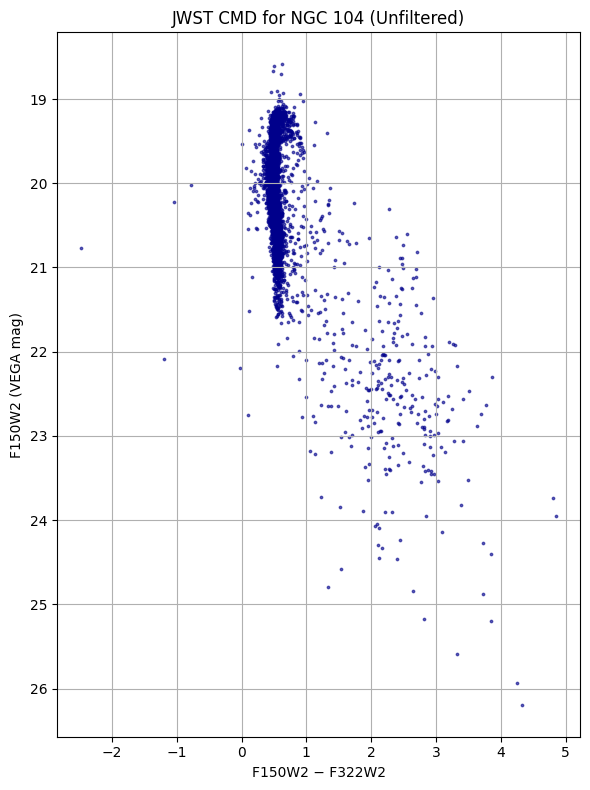

In [34]:
# Load JWST catalogs (T002 epoch)
f150 = Table.read('/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F150W2/jw02559-o001_t001_nircam_clear-f150w2_cat.ecsv')
f322 = Table.read('/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F322W2/jw02559-o001_t001_nircam_clear-f322w2_cat.ecsv')

# Filter sources with valid magnitudes
mask_f150 = np.isfinite(f150['aper_total_vegamag'])
mask_f322 = np.isfinite(f322['aper_total_vegamag'])

f150_clean = f150[mask_f150]
f322_clean = f322[mask_f322]

# Convert to SkyCoord for crossmatching
coords_f150 = SkyCoord(f150_clean['sky_centroid'], frame='icrs')
coords_f322 = SkyCoord(f322_clean['sky_centroid'], frame='icrs')

# Match within 0.05 arcsec
idx, d2d, _ = coords_f150.match_to_catalog_sky(coords_f322)
match_mask = d2d < 0.05 * u.arcsec

# Build matched table
matched = f150_clean[match_mask]
matched['f322w2_mag'] = f322_clean[idx[match_mask]]['aper_total_vegamag']
matched['color'] = matched['aper_total_vegamag'] - matched['f322w2_mag']  # F150W2 − F322W2

# Plot the CMD
plt.figure(figsize=(6, 8))
plt.scatter(matched['color'], matched['aper_total_vegamag'], s=3, color='darkblue', alpha=0.6)
plt.gca().invert_yaxis()
plt.xlabel("F150W2 − F322W2")
plt.ylabel("F150W2 (VEGA mag)")
plt.title("JWST CMD for NGC 104 (Unfiltered)")
plt.grid(True)
plt.tight_layout()
plt.show()


# checking cell

In [109]:


hst_cat = Table.read('hst_f606w_psf_stmag.ecsv', format='ascii.ecsv')
print(hst_cat.colnames)


['x', 'y', 'flux', 'mag']


# Get JWST Sky Coordinates

# Make sure your JWST catalog includes RA/Dec. From earlier, it looks like your JWST catalog column is 'sky_centroid', which stores SkyCoord-like strings.

In [71]:

# Load JWST catalog
jwst_cat = Table.read('/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F150W2/jw02559-o001_t001_nircam_clear-f150w2_cat.ecsv', format='ascii.ecsv')

# Parse sky_centroid column into actual SkyCoord objects
jwst_coords = SkyCoord(jwst_cat['sky_centroid'])


# Cell 20: Extract Observation Epoch from FITS Headers

In [38]:


# --- HST FITS (DRC file) ---
with fits.open(hst_f606_files[0]) as hdul_hst:
    hst_date_obs = hdul_hst[0].header.get('DATE-OBS')
    print("HST DATE-OBS:", hst_date_obs)

# --- JWST FITS (i2d file) ---
with fits.open("/media/harshit/official/Astrostats/term-paper/JWST _NGC-104-(usable data)/F150W2/jw02559-o001_t001_nircam_clear-f150w2_i2d.fits") as hdul_jwst:
    jwst_date_obs = hdul_jwst[0].header.get('DATE-OBS')
    print("JWST DATE-OBS:", jwst_date_obs)

# --- Compute time baseline in years ---
t1 = Time(hst_date_obs)
t2 = Time(jwst_date_obs)
baseline_years = (t2 - t1).to('yr').value
print(f"Baseline: {baseline_years:.2f} years")


HST DATE-OBS: 2010-03-04
JWST DATE-OBS: 2022-09-14
Baseline: 12.53 years


# Cell 21 :Calculating PMs and Plotting Full VPD

--- Calculating AND Correcting PMs, then Plotting VPD ---
Loaded 1871 (cleaned) matched stars.
Raw PMs calculated.
Calculated WCS Offset (PM_RA, PM_Dec): (1.32, 0.50) mas/yr
This offset will be subtracted to center the cluster at (0,0).
PMs have been corrected for WCS offset.
Final Corrected VPD plot saved to: vpd_final_corrected.png


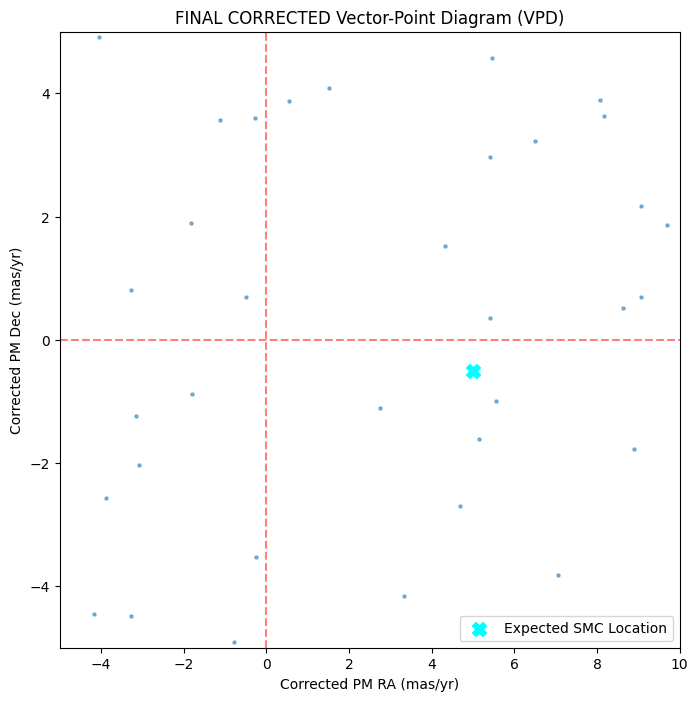

Catalog with corrected PMs saved to: master_catalog_with_pms.ecsv
'master_cat' is now ready for the cluster cut (Cell 6).


In [60]:
# --- FINAL PM CELL: Correct for WCS Offset and Plot VPD ---
print("--- Calculating AND Correcting PMs, then Plotting VPD ---")
try:
    # --- 1. Load the FINAL Master Catalog ---
    try:
        master_cat = Table.read('master_catalog_combined.ecsv')
    except FileNotFoundError:
        print("ERROR: 'master_catalog_FINAL.ecsv' not found.")
        print("Please re-run the final matching cell (with 0.9 arcsec radius) first.")
        raise
    print(f"Loaded {len(master_cat)} (cleaned) matched stars.")

    # --- 2. Calculate RAW Proper Motions ---
    baseline_years = 12.53 * u.yr
    
    coords_hst = SkyCoord(ra=master_cat['ra_hst']*u.deg, dec=master_cat['dec_hst']*u.deg)
    coords_jwst = SkyCoord(ra=master_cat['ra_jwst']*u.deg, dec=master_cat['dec_jwst']*u.deg)

    delta_ra, delta_dec = coords_hst.spherical_offsets_to(coords_jwst)
    
    master_cat['pm_ra_raw'] = (delta_ra.to(u.mas) / baseline_years).value
    master_cat['pm_dec_raw'] = (delta_dec.to(u.mas) / baseline_years).value
    print("Raw PMs calculated.")

    # --- 3. Find the *True* WCS Offset ---
    # The median PM of the *entire cluster* is the systematic offset.
    wcs_offset_ra = np.median(master_cat['pm_ra_raw'])
    wcs_offset_dec = np.median(master_cat['pm_dec_raw'])
    print(f"Calculated WCS Offset (PM_RA, PM_Dec): ({wcs_offset_ra:.2f}, {wcs_offset_dec:.2f}) mas/yr")
    print("This offset will be subtracted to center the cluster at (0,0).")

    # --- 4. Create NEW, Corrected PM Columns ---
    # Corrected PM = Raw PM - WCS Offset
    master_cat['pm_ra_corr'] = master_cat['pm_ra_raw'] - wcs_offset_ra
    master_cat['pm_dec_corr'] = master_cat['pm_dec_raw'] - wcs_offset_dec
    print("PMs have been corrected for WCS offset.")

    # --- 5. Plot the FINAL, Corrected VPD ---
    plt.figure(figsize=(8, 8))
    
    # Plot the *corrected* PMs
    plt.scatter(master_cat['pm_ra_corr'], master_cat['pm_dec_corr'], 
                alpha=0.5, s=5) # Bigger dots
    
    plt.xlim(-5, 10)
    plt.ylim(-5, 5)
    
    plt.title('FINAL CORRECTED Vector-Point Diagram (VPD)')
    plt.xlabel('Corrected PM RA (mas/yr)')
    plt.ylabel('Corrected PM Dec (mas/yr)')
    
    plt.axvline(0, c='red', ls='--', alpha=0.5)
    plt.axhline(0, c='red', ls='--', alpha=0.5)
    plt.scatter(5, -0.5, c='cyan', marker='X', s=100, label='Expected SMC Location')
    
    plt.legend()
    output_fig = 'vpd_final_corrected.png'
    plt.savefig(output_fig, dpi=150)
    print(f"Final Corrected VPD plot saved to: {output_fig}")
    plt.show()
    
    # --- 6. Save the Final Catalog with Corrected PMs ---
    output_pm_cat = 'master_catalog_with_pms.ecsv'
    master_cat.write(output_pm_cat, format='ascii.ecsv', overwrite=True)
    print(f"Catalog with corrected PMs saved to: {output_pm_cat}")
    print("'master_cat' is now ready for the cluster cut (Cell 6).")

except Exception as e:
    print(f"An error occurred: {e}")